# Lab 2: Utility-Scale Layer Fidelity Experiment

Samantha Barron, Haimeng Zhang

In this lab we will show a guided construction of how to calculate the EPLG (Error Per Layered Gate) and LF (Layer Fidelity). These metrics quantify error rates in a circuit, and are particularly useful in understanding the overhead required to run error mitigation at utility-scale workloads.

For more details on the background of these metrics, see the [Quantum Research Blog post](https://www.ibm.com/quantum/blog/quantum-metric-layer-fidelity) or the associated technical paper, [Benchmarking Quantum Processor Performance at Scale](https://arxiv.org/abs/2311.05933). You can also find an implementation of the Layer Fidelity experiment [here](https://github.com/qiskit-community/qiskit-device-benchmarking/blob/main/notebooks/layer_fidelity.ipynb) using `qiskit-experiments` module, whereas, in this notebook, we will directly use Qiskit Runtime Primitives for circuit execution.

The first few parts of this lab contain graded exercises, whereas the latter portions of this lab are a guided walkthrough of how to use the Qiskit Runtime to do these utility-scale calculations.

Table of Contents:
- In Section 0 we list the package requirement to run this notebook.
- In Sections 1-3 we will set up the layers and associated circuits which define the disjoint sets of qubits on which we will perform EPLG calculations.
- In Section 4 we construct the total EPLG circuits.
- In Section 5-7 we construct the `BindingsArray`, `ObservablesArray`s, and `EstimatorPub`s for the EPLG characterization.
- In Section 8 we submit these to the `EstimatorV2` Qiskit Runtime Primitive.
- In Section 9 we perform the data analysis and fittings used to extract the EPLG and LF with the resulting data.

# Part 0: Requirements

To run this notebook, you will need to install the following packages:

For circuit construction and execution on the IBM Quantum hardware:
```
qiskit >= 1.0.0
qiskit-ibm-runtime >= 0.21.1
```
For data analysis and display:
```
lmfit
pandas
```

In [1]:
# !pip install qiskit[visualization]==1.1.0 -q
# # Use the following if you are on MacOS/zsh
# #!pip install 'qiskit[visualization]'==1.1.0
# !pip install qiskit_aer -q
# !pip install setuptools -q
# !pip install qiskit_ibm_runtime -q
# !pip install matplotlib -q
# !pip install pylatexenc -q
# !pip install prototype-zne -q
# !pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -q

In [1]:
# import of required libraries and modules
from qc_grader.challenges.qgss_2024 import *

from math import pi
from qiskit.circuit.library import QFT
from qiskit.providers.fake_provider import GenericBackendV2, generic_backend_v2
generic_backend_v2._NOISE_DEFAULTS["cx"] = (5.99988e-06, 6.99988e-06, 1e-5, 5e-3)

from qiskit import transpile, QuantumCircuit
from qiskit.circuit import Gate
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import CouplingMap, StagedPassManager, PassManager, AnalysisPass, TransformationPass
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map, plot_circuit_layout, plot_distribution, array_to_latex
from qiskit.transpiler.preset_passmanagers.common import generate_unroll_3q, generate_embed_passmanager
from qiskit.quantum_info import hellinger_fidelity
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.dagcircuit import DAGCircuit
from qiskit_ibm_runtime.fake_provider import FakeTorino
from qiskit_ibm_runtime import IBMBackend


# Transpiler Passes
## Layout passes
from qiskit.transpiler.passes.layout.csp_layout import CSPLayout
from qiskit.transpiler.passes.layout.dense_layout import DenseLayout
from qiskit.transpiler.passes.layout.sabre_layout import SabreLayout
from qiskit.transpiler.passes.layout.vf2_layout import VF2Layout
from qiskit.transpiler.passes.layout.trivial_layout import TrivialLayout

## Routing passes
from qiskit.transpiler.passes.routing.basic_swap import BasicSwap
from qiskit.transpiler.passes.routing.lookahead_swap import LookaheadSwap
from qiskit.transpiler.passes.routing.sabre_swap import SabreSwap
from qiskit.transpiler.passes.routing.stochastic_swap import StochasticSwap
from qiskit.transpiler.passes.routing.star_prerouting import StarPreRouting

## Synthesis passes (passes for the translation stage)
from qiskit.circuit import SessionEquivalenceLibrary
from qiskit.circuit.equivalence_library import SessionEquivalenceLibrary
from qiskit.transpiler.passes.basis.basis_translator import BasisTranslator
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HighLevelSynthesis
### The next pass could also be considered an optimization pass.
from qiskit.transpiler.passes.synthesis.unitary_synthesis import UnitarySynthesis

## Optimization passes
from qiskit.transpiler.passes.optimization.collect_1q_runs import Collect1qRuns
from qiskit.transpiler.passes.optimization.collect_2q_blocks import Collect2qBlocks
from qiskit.transpiler.passes.optimization.consolidate_blocks import ConsolidateBlocks
from qiskit.transpiler.passes.optimization.commutative_cancellation import CommutativeCancellation

In [2]:
%set_env QXToken=ce3e186d80dd249576c5dfee58c617785f7573261c22849d51910bc52f108b5eb590c7830cc63d97878ec090ea050149948f1271e3fe10a9f101afccc3aa883a

env: QXToken=ce3e186d80dd249576c5dfee58c617785f7573261c22849d51910bc52f108b5eb590c7830cc63d97878ec090ea050149948f1271e3fe10a9f101afccc3aa883a


# Part 1: Define 1-D Chain
To start, we will choose a backend. In this lab you can choose whatever backend you want.

In order to compute the EPLG and LF, we need to choose a chain of qubits on the device to characterize. The first problem is this, you should provide:
1. A chain of qubits on the device which is a simply connected path graph of qubits on the device. I.e., provide a list `PATH_ANSWER: list[int]` whose elements are physical qubits on the device, and adjacent elements of the list are connected on the coupling map by edges. The list should contain at least `3` elements.
2. The backend you have chosen: `BACKEND: IBMBackend`.

Answers to grade:
- `PATH_ANSWER: list[int]`
- `BACKEND: IBMBackend`

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel='ibm_quantum',
    token='ce3e186d80dd249576c5dfee58c617785f7573261c22849d51910bc52f108b5eb590c7830cc63d97878ec090ea050149948f1271e3fe10a9f101afccc3aa883a',
    overwrite=True,
    set_as_default=True,
)

In [4]:
service = QiskitRuntimeService()
# BACKEND = service.least_busy(min_num_qubits=127)
BACKEND = service.backend('ibm_osaka')
BACKEND.name

'ibm_osaka'

![alt chosen_path](chosen_path_ibm_osaka.png "Chosen Path")

Choosing a path from 51-37, 52, 56-70, 74, to 89-75 total 47 qubits

In [5]:
def create_custom_range(ranges):
    result = []
    for r in ranges:
        if '-' in r:
            start, end = map(int, r.split('-'))
            if start <= end:
                result.extend(range(start, end + 1))
            else:
                result.extend(range(start, end - 1, -1))
        else:
            result.append(int(r))
    return result

# path of arbitrary choice

# ranges = ['13-0', '14', '18-32', '36', '51-37', '52', '56-70', '74', '89-75', '90', '94-108', '112', '126-113']
# ranges = ['20-28', '35', '47-49', '55', '68-60', '53', '41-39', '33']
ranges = ['51-37', '52', '56-70', '74', '89-75']

custom_list = create_custom_range(ranges)
print(custom_list)

[51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 74, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75]


In [6]:
# part 1: pick a backend and define 1-D chain

### Your code goes here ###
# skip_connections = [15, 16, 17, 33, 34, 35,
#                     53, 54, 55, 71, 72, 73,
#                     91, 92, 93, 109, 110, 111]
# BACKEND = FakeTorino()
coupling_map = BACKEND.coupling_map
# PATH_ANSWER = list(coupling_map.get_edges())
# PATH_ANSWER = [i for i in range(BACKEND.num_qubits)]
# PATH_ANSWER = [i for i in range(75, 89)]
# PATH_ANSWER = [i for i in range(50) if i not in skip_connections]
PATH_ANSWER = custom_list
print(len(PATH_ANSWER), PATH_ANSWER)

47 [51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 74, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75]


In [7]:
# grade part 1
from qc_grader.challenges.qgss_2024 import grade_lab2_ex1
grade_lab2_ex1(PATH_ANSWER, BACKEND)

Submitting your answer. Please wait...
Nice work, all your answers look correct!


# Part 2: Define Disjoint Layers

Next, we need to form two sets of edges which correspond to the different layers we will use in benchmarking, say `LAYER_1_ANSWER` and `LAYER_2_ANSWER`, each with type `list[tuple[int, int]]`. These layers should have the following properties:
- Each `LAYER_i_ANSWER` contains edges on distinct sets of qubits, e.g. `(0, 1)` and `(1, 2)` cannot both be in `LAYER_i_ANSWER`, since they both contain `1`.
- Every qubit in `PATH_ANSWER` must be contained in at least one of the `LAYER_i`s.

Answers to grade:
- `LAYER_1_ANSWER: list[tuple[int, int]]`
- `LAYER_2_ANSWER: list[tuple[int, int]]`
- `PATH_ANSWER: list[int]` (same as before)

In [9]:
# # plot_circuit_layout(transpiled_qc, backend=backend)
# BACKEND.coupling_map.draw()

In [8]:
edges = coupling_map.get_edges()
print(edges)

EdgeList[(55, 49), (66, 73), (103, 102), (22, 15), (31, 30), (35, 47), (39, 33), (43, 34), (60, 53), (64, 54), (71, 77), (81, 82), (86, 85), (96, 109), (100, 99), (116, 117), (123, 122), (17, 12), (21, 20), (24, 34), (28, 35), (40, 41), (45, 54), (50, 51), (58, 71), (68, 67), (81, 72), (85, 84), (88, 89), (98, 91), (101, 102), (109, 114), (118, 119), (122, 111), (125, 126), (9, 8), (13, 12), (14, 0), (24, 23), (27, 28), (31, 32), (33, 20), (37, 52), (42, 41), (45, 46), (49, 50), (59, 58), (62, 72), (66, 65), (69, 70), (87, 93), (90, 94), (92, 83), (97, 98), (104, 111), (114, 115), (118, 110), (125, 124), (2, 3), (6, 7), (11, 10), (14, 18), (21, 22), (25, 26), (30, 29), (40, 39), (43, 44), (48, 47), (52, 56), (59, 60), (65, 64), (68, 69), (79, 80), (84, 83), (87, 88), (90, 75), (96, 97), (100, 110), (103, 104), (120, 121), (126, 112), (2, 1), (6, 5), (9, 10), (17, 30), (18, 19), (23, 22), (27, 26), (39, 38), (42, 43), (46, 47), (51, 36), (57, 56), (64, 63), (68, 55), (76, 77), (81, 80),

In [9]:
def make_pairs(path: list):
    for i in range(len(path) - 1):
        yield path[i], path[i+1]

def make_layers(pairs:list[tuple[int, int]]):
    layer1 = []
    layer2 = []
    for i, pair in enumerate(pairs):
        # print(pair)
        n1, n2 = pair
        if tuple(pair) not in list(edges):
            if tuple(reversed(pair)) in list(edges):
                pair = tuple(reversed(pair))
                # print(pair)

        if tuple(pair) in list(edges):
            (n1, n2) = pair
            if i%2 == 0:
                layer1.append([n1, n2])
            else:
                layer2.append([n1, n2])
    return layer1, layer2
LAYER_1_ANSWER, LAYER_2_ANSWER = make_layers(make_pairs(PATH_ANSWER))

In [10]:
print(LAYER_1_ANSWER)
print(LAYER_2_ANSWER)


[[50, 51], [48, 49], [46, 47], [45, 44], [42, 43], [40, 41], [39, 38], [37, 52], [57, 56], [59, 58], [61, 60], [63, 62], [65, 64], [67, 66], [68, 69], [74, 70], [88, 89], [87, 86], [85, 84], [83, 82], [81, 80], [78, 79], [76, 77]]
[[49, 50], [48, 47], [45, 46], [43, 44], [42, 41], [40, 39], [37, 38], [52, 56], [57, 58], [59, 60], [61, 62], [64, 63], [66, 65], [68, 67], [69, 70], [89, 74], [87, 88], [86, 85], [84, 83], [81, 82], [79, 80], [78, 77], [75, 76]]


In [11]:
# grade part 2
from qc_grader.challenges.qgss_2024 import grade_lab2_ex2
grade_lab2_ex2(LAYER_1_ANSWER, LAYER_2_ANSWER, PATH_ANSWER, BACKEND)

Submitting your answer. Please wait...
Nice work, all your answers look correct!


# Part 3: Construct Clifford Entangling Layers
Now we can use the `LAYER_i` from the previous problem to construct the `QuantumCircuit`s for each layer, which we will use for the EPLG experiments. Now it's your job to construct two circuits, `CIRC_1_ANSWER` and `CIRC_2_ANSWER`.
- Each of them should contain a two-qubit Clifford gate for every pair in `LAYER_1_ANSWER` and `LAYER_2_ANSWER` from before.
- The two-qubit Clifford gate (`GATE_NAME`) must be one provided by the backend you choose, i.e. it is in `backend.basis_gates`, should be one of `'ecr'`, `'cz'` or `'cx'` depending on your backend.

Answers to grade:
- `CIRCUIT_1_ANSWER: QuantumCircuit`
- `CIRCUIT_2_ANSWER: QuantumCircuit`
- `LAYER_1_ANSWER: list[tuple[int, int]]` (same as before)
- `LAYER_2_ANSWER: list[tuple[int, int]]` (same as before)
- `GATE_NAME: str`

In [12]:
# part 2: define disjoint layers from a 1D chain
from qiskit.quantum_info import Clifford

### Your code goes here ###

GATE_NAME = 'cx'

qc1 = QuantumCircuit(max(PATH_ANSWER)+1)
for pair in LAYER_1_ANSWER:
    qc1.cx(pair[0], pair[1])


qc2 = QuantumCircuit(max(PATH_ANSWER)+1)
for pair in LAYER_2_ANSWER:
    qc2.cx(pair[0], pair[1])

CIRC_1_ANSWER = qc1
CIRC_2_ANSWER = qc2

In [15]:
# qc1.decompose().draw(fold = -1)


In [16]:
# qc2.decompose().draw(fold = -1)

In [13]:
# grade part 3
from qc_grader.challenges.qgss_2024 import grade_lab2_ex3
grade_lab2_ex3(CIRC_1_ANSWER, LAYER_1_ANSWER, GATE_NAME, BACKEND)
grade_lab2_ex3(CIRC_2_ANSWER, LAYER_2_ANSWER, GATE_NAME, BACKEND)

Submitting your answer. Please wait...
Nice work, all your answers look correct!
Submitting your answer. Please wait...
Nice work, all your answers look correct!


# Part 4: Construct EPLG Experiment Circuits

*No grading for this part*

In this part, we will use the circuits you constructed to construct the total EPLG circuits.  These circuits interleave the layers from before between layers of random Clifford gates.

A few technical asides:
1. There is a slight difference between the circuits constructed here and those defined in the EPLG paper. For a circuit of depth $d$ (for even $d$), we randomly sample 1q Clifford gates for $d/2$ layers, and then we invert the circuit for the last $d/2$ layers. This provides a simple implmentation for our purposes, and the details of this difference are beyond the scope of this lab.
2. We perform 1q Clifford sampling by taking advantage of the fact that for backends whose single qubit gates are composed of $R_z(\theta_1) \sqrt{X} R_z(\theta_2) \sqrt{X} R_z(\theta_3)$, when $\theta_i \in \{ \pm \pi / 2, \pm \pi, 0 \}$, the resulting single qubit gate is a Clifford. This allows us to randomly sample 1q Clifford gates simply by changing parameters.

In [14]:
from qiskit.circuit import Parameter
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

def eplg_circuit(num_qubits: int, depth: int, layer: QuantumCircuit, qubits: tuple[int, ...]) -> QuantumCircuit:
    if depth % 2 != 0:
        raise ValueError(f"The depth must be even, got {depth}")

    def parameters():
        _depth = 0
        while True:
            for zi in range(3):
                for q in range(num_qubits):
                    yield Parameter(f"d{_depth}_q{q}_z{zi}")
            _depth += 1
    _parameters = parameters()

    circ = QuantumCircuit(num_qubits)

    def _1q_layer():
        for j in range(3):
            for k in qubits:
                circ.rz(next(_parameters), k)
            if j == 2:
                continue
            circ.sx(qubits)

    for _depth in range(depth // 2):
        circ.barrier(qubits)
        _1q_layer()
        circ.barrier(qubits)
        circ.compose(layer, inplace=True)
    circ.barrier(qubits)
    _1q_layer()
    circ.barrier(qubits)

    # Assuming mirroring is fine
    circ = circ.compose(circ.inverse())

    circ.measure_active()

    pm = generate_preset_pass_manager(basis_gates=["ecr", "sx", "rz"], optimization_level=0)
    circ = pm.run(circ)

    circ.metadata["layer_depth"] = depth
    circ.metadata["qubits"] = qubits
    circ.metadata["num_qubits"] = num_qubits

    return circ

Here are examples of the EPLG circuits for depth $d=4$. In a later part we will use this function to construct circuits for varying $d$.

In [15]:
example_circuit_1 = eplg_circuit(
    num_qubits=BACKEND.num_qubits,
    depth=4,
    layer=CIRC_1_ANSWER,
    qubits=PATH_ANSWER,
)

In [16]:
example_circuit_2 = eplg_circuit(
    num_qubits=BACKEND.num_qubits,
    depth=4,
    layer=CIRC_2_ANSWER,
    qubits=PATH_ANSWER,
)

# Part 5: Construct `BindingsArray`s

*No grading for this part*

In the previous section, the circuits we constructed are parameterized such that if we sample with the appropriate values, they will always produce random single-qubit Clifford gates.

For our EPLG calculations, we need to sample lots of sets of parameters. This is expressed conveniently with the `BindingsArray`. The `BindingsArray` can be thought of as an array whose elements correspond to sets of parameters and their bound values.

For example, if we have a circuit with $k$ parameters, and we need to sample all of the parameters $m$ times, the `BindingsArray` that accomplishes this would have shape `(m,)`. Similarly, if we want to have a more complicated set of bindings to perform, our `BindingsArray` can have arbitrary shape, and supports `numpy`-like reshaping operations, slicing, etc.

In this section, we will construct a function which accepts a `QuantumCircuit`, the number of samples we want to perform, and a `numpy` RNG to perform the single-qubit Clifford sampling. We will use this later on to produce our `EstimatorPub`s.

In [17]:
import numpy as np

from qiskit.primitives.containers.bindings_array import BindingsArray

def get_clifford_rz_samples(
    circ: QuantumCircuit,
    num_samples: int,
    rng: np.random.Generator,
) -> BindingsArray:
    """Uniformly sample the Rz parameters in a `QuantumCircuit`
    from -pi, -pi/2, 0, +pi/2, +pi.
    """

    _allowed_ops = {'rz', 'sx', 'sxdg', 'ecr', 'barrier', 'measure'}
    if (_other := set(circ.count_ops().keys()) - _allowed_ops):
        raise ValueError(f"Circuit must only contain ops: {_allowed_ops}, got {_other}")

    sampled_pars = rng.integers(-2, 3, size=(num_samples, len(circ.parameters))) * (np.pi/2)

    return BindingsArray({
        tuple(circ.parameters): sampled_pars
    })

As an example, we can take each of our circuits and produce bindings

In [18]:
num_samples = 10
ARRAY_1_ANSWER = get_clifford_rz_samples(
    circ=example_circuit_1,
    num_samples=num_samples,
    rng=np.random.default_rng(42))

In [19]:
# grade part 4
from qc_grader.challenges.qgss_2024 import grade_lab2_ex4
grade_lab2_ex4(ARRAY_1_ANSWER, example_circuit_1, num_samples)

Submitting your answer. Please wait...
Nice work, all your answers look correct! 
 Notice that the shape of the BindingsArray is [10], and there are {num_parameters} parameters.


Notice that despite the large number of parameters, the `BindingsArray` has shape `(10,)`, meaning it has `10` entries. As we discussed before, this is because its elements correspond to sets of parameters and their bound values

# Part 6: Make `ObservablesArray`s

*No grading for this part*

The only remaining thing that we need to produce an `EstimatorPub` is an `ObservablesArray`. The `ObservablesArray` can be seen as a array whose elements are observables. In our case, they will be `SparsePauliOp`s.

In order to calculate the EPLG and LF, we need to calculate the expectation values $\text{Tr}\left( \rho \ket{00}_{i,j}\bra{00}_{i,j}\right)$ and $\text{Tr}\left( \rho \ket{0}_{i}\bra{0}_{i}\right)$ for qubits $i$, $j$ depending on the layers we chose before.

Alternatively we could do this using the `SamplerV2` rather than the `EstimatorV2`. This would come with the tradeoff of having more post-processing that we have to do, but we can have the `EstimatorV2` do this for us by constructing the projectors $\ket{0}_{i}\bra{0}_{i}$ and $\ket{00}_{i,j}\bra{00}_{i,j}$ and using them as observables.

This means that the expectation values we get back from the `EstimatorV2` will be the process fidelities that we're interested in!

In [20]:
import numpy as np
from itertools import product
from qiskit.quantum_info import SparsePauliOp

def process_fidelity_observable(num_qubits: int, qubits: tuple[int, ...]) -> SparsePauliOp:
    """Produces the all 0 projector on `qubits` tensored with the identity on all other qubits"""
    pauli_strings = []

    for p_sub_str in product(["I", "Z"], repeat=len(qubits)):
        p_str = ["I"] * num_qubits
        for qi, pi in zip(qubits, p_sub_str):
            p_str[qi] = pi
        pauli_strings.append("".join(p_str[::-1]))

    return SparsePauliOp(pauli_strings, np.ones(len(pauli_strings)) / 2**len(qubits))

Now we need to produce `ObservablesArray`s which correspond to the projectors we are interested in, i.e. the process fidelities for subsets of our path.

In [21]:
from qiskit.primitives.containers.observables_array import ObservablesArray

LAYER_1_SUBSYSTEMS = LAYER_1_ANSWER + [(q,) for q in set(PATH_ANSWER) - set(item for sublist in LAYER_1_ANSWER for item in sublist)]
LAYER_2_SUBSYSTEMS = LAYER_2_ANSWER + [(q,) for q in set(PATH_ANSWER) - set(item for sublist in LAYER_2_ANSWER for item in sublist)]

LAYER_1_OBSERVABLES = ObservablesArray([process_fidelity_observable(BACKEND.num_qubits, qubits) for qubits in LAYER_1_SUBSYSTEMS])
LAYER_2_OBSERVABLES = ObservablesArray([process_fidelity_observable(BACKEND.num_qubits, qubits) for qubits in LAYER_2_SUBSYSTEMS])

Note that the `LAYER_i_OBSERVABLES` have a shape which corresponds to the number of subsystems in each layer.

Since all of the observables in our `ObservablesArray`s are diagonal in the computational basis (i.e. they only consist of Paulis which have $I$ and $Z$ terms), the `EstimatorV2` does not need to compute expectation values in additional bases.

In [22]:
LAYER_1_OBSERVABLES.shape == (len(LAYER_1_SUBSYSTEMS),)

True

In [23]:
LAYER_2_OBSERVABLES.shape == (len(LAYER_2_SUBSYSTEMS),)

True

# Part 7: Make Sequence of `EstimatorPub`s

*No grading for this part*

Finally, we can construct our `EstimatorPub`s. The [`EstimatorPub`](https://github.com/Qiskit/qiskit/blob/main/qiskit/primitives/containers/estimator_pub.py#L36) is can be seen as a tuple consisting of a `QuantumCircuit`, an `ObservablesArray`, and a `BindingsArray` (and optionally a precision). Given an `EstimatorPub` with a given shape, the `EstimatorV2` will return arrays of expectation values (and their standard deviations) whose shape is the same as the input `EstimatorPub`.

In order to construct the `EstimatorPub`s needed to do the EPLG calculations, we need `EstimatorPub`s which vary in
- the input circuit (i.e. one for each disjoint set of edges) (in our case `2`)
- the depth of the circuit (we have chosen `6` depths here by default).

Therefore, we will have $2 \times 6 = 12$ `EstimatorPub`s total. Within each of these, we have `10` twirling samples, and `k` fidelities (which depends on the path you chose, this should roughly be half of the length of the path). So we have $12$ `EstimatorPub`s, each with $10 k$ elements.

Therefore, the total number of expectation values that we *expect* to receive is $120k$. For a length $30$ chain, $k = 15$, meaning we should roughly $1,800$ expectation values back overall (depending on the edges of the chain).

In [24]:
rng = np.random.default_rng(42)
num_samples = 10
depths = [2, 4, 8, 16, 32, 64]

In [25]:
from qiskit.primitives.containers.estimator_pub import EstimatorPub

estimator_pubs = []
for depth in depths:
    for layer, name, observables in [(CIRC_1_ANSWER, "circ_1", LAYER_1_OBSERVABLES), (CIRC_2_ANSWER, "circ_2", LAYER_2_OBSERVABLES)]:
        circ = eplg_circuit(
            num_qubits=BACKEND.num_qubits,
            depth=depth,
            layer=layer,
            qubits=PATH_ANSWER,
        )
        circ.metadata["layer_idx"] = name
        bindings_array = get_clifford_rz_samples(
            circ=circ,
            num_samples=num_samples,
            rng=rng,
        )

        # We need to reshape the `ObservablesArray`s and `BindingsArray`s so they
        # can be broadcasted.
        # https://numpy.org/doc/stable/user/basics.broadcasting.html#basics-broadcasting
        estimator_pubs.append(EstimatorPub(
            circuit=circ,
            observables=observables.reshape((*observables.shape, 1)),
            parameter_values=bindings_array.reshape((1, *bindings_array.shape)),
        ))

As a sanity check, we can count the number of expectation values we should obtain overall from the shape of the `EstimatorPub`s.

In [26]:
num_evs_expected = 0
for pub in estimator_pubs:
    num_evs_expected += np.prod(estimator_pubs[0].shape)
num_evs_expected

2880

# Part 8: Submit to Runtime

*No grading for this part*

Finally, we are ready to hand off our `EstimatorPub`s to the `EstimatorV2`.

Since the calculation of EPLG is SPAM-robust, we should turn off measurement mitigation, which is enabled by default.

In [31]:
# service = QiskitRuntimeService()
# BACKEND = service.least_busy(min_num_qubits=127)
# BACKEND.name

In [32]:
from qiskit_ibm_runtime import EstimatorV2
estimator = EstimatorV2(backend=BACKEND)
estimator.options.resilience.measure_mitigation = False

In [33]:
cm  = BACKEND.coupling_map
print("Supported basis gates:", BACKEND.operation_names)

Supported basis gates: ['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'switch_case', 'if_else', 'for_loop', 'delay']


Now we can run the `EstimatorV2` with our `EstimatorPub`s and wait for the result.

With the default settings in this notebook, this should take no more than 10 minutes to complete (not accounting for queue time).

In [34]:
estimator_job = estimator.run(estimator_pubs)

And we can get the `PrimitiveResult` with

In [35]:
job_id = estimator_job.job_id()
print(f"Job Status: {estimator_job.status()} -- Job ID: {job_id}")

Job Status: QUEUED -- Job ID: ctkzj0g4gjh0008p72tg


In [27]:
job = service.job('ctkzj0g4gjh0008p72tg')

In [28]:
primitive_result = job.result()

primitive_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(24, 10), dtype=float64>), stds=np.ndarray(<shape=(24, 10), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(24, 10), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {'layer_depth': 2, 'qubits': [51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 74, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75], 'num_qubits': 127, 'layer_idx': 'circ_1'}, 'num_randomizations': 32}), PubResult(data=DataBin(evs=np.ndarray(<shape=(24, 10), dtype=float64>), stds=np.ndarray(<shape=(24, 10), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(24, 10), dtype=float64>)), metadata={'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {'layer_depth': 2, 'qubits': [51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 74, 8

# Part 9: Data Analysis

The final step is to perform the fittings of the decay curves to perform the EPLG analysis.

Let's first grab some of the relevant data from the `PrimitiveResult`.

In [29]:
data_out = {
    "evs": [pub_res.data.evs for pub_res in primitive_result],
    "stds": [pub_res.data.stds for pub_res in primitive_result],
    "result_metadata": primitive_result.metadata,
    "pub_metadata": [pub_res.metadata for pub_res in primitive_result]
}

Now we can rearrange the expectation values into an array in a convenient form, as well as average over the randomized Cliffords.

In [30]:
# evs_at_depth is a
evs_at_depth = np.zeros((len(depths), data_out['evs'][0].shape[0]*2))
for i in range(len(depths)):
    layer1_evs = np.average(data_out['evs'][2*i], axis=-1)
    layer2_evs = np.average(data_out['evs'][2*i+1], axis=-1)
    evs_at_depth[i,:] = np.array([item for pair in zip(layer1_evs, layer2_evs) for item in pair])

The resulting shape has two axes, one for the depth (axis `0`, with shape `6`) and one for the number of subsystem fidelities (axis `1`, dependent on your path).

In [31]:
evs_at_depth.shape

(6, 48)

Now we can plot the decay curves for the different subsystems.

In [32]:
import matplotlib.pyplot as plt

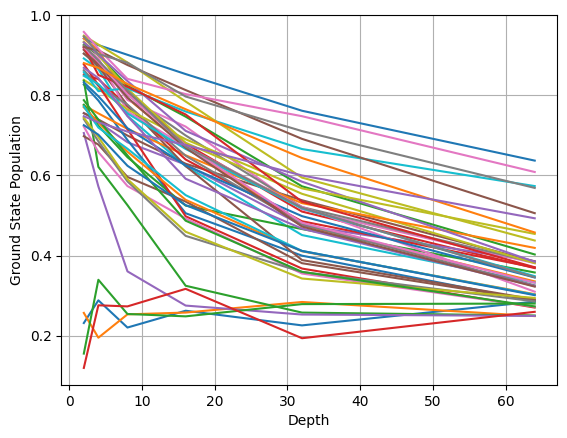

In [33]:
ax = plt.gca()
for i in range(evs_at_depth.shape[1]):
    ax.plot(depths, evs_at_depth[:,i])

ax.set_ylabel("Ground State Population")
ax.set_xlabel("Depth")
ax.grid()

Now we need to fit these to exponential decays, we can do this with the `lmfit` python package. The exponential decay has the following form:
$$
A\alpha^L+B
$$
where $\alpha$ is the error rate, $L$ denotes the number of cycles (depth) in the EPLG circuits, parameters $A$ and $B$ are the fitting parameters to capture the SPAM (state preparation and measurement) errors.

In [34]:
import lmfit
model= lmfit.models.ExpressionModel(
            expr="a * alpha ** x + b",
            name="rb_decay")

params_dict = {
    'a': {'value': 1.0,
            'min': -1.0,
            'max': 1.0,
            },
    'b': {'value': 0.0,
            'min': -1.0,
            'max': 1.0,
            },
    'alpha': {'value': 0.9,
              'min': 0.0,
              'max': 1.0
              },
}
p = model.make_params(**params_dict)

In [35]:
alphas = []
for i in range(evs_at_depth.shape[-1]):
    result = model.fit(evs_at_depth[:,i], p, x=depths)
    alphas.append(result.params['alpha'].value)

Now we can finally use the expressions in the EPLG paper to compute process fidelities.
$\alpha$ is related to the average gate error vis
$$
\epsilon = \frac{D-1}{D} (1-\alpha)
$$
where $D$ denotes the the dimension of the Hilbert space, e.g., $D=4$ for two-qubit processes. The average gate fidelity is $F_g = 1-\epsilon$.
The process fidelity is related to the average gate fidelity via
$$
F_g=\frac{DF_p+1}{D+1}
$$

In [36]:
def cal_process_fid(alpha, D=4):
    epsilon = (D-1) * (1 - alpha)/D
    Fg = 1 - epsilon
    Fp = ((D+1) * Fg -1)/D
    return Fp

And with a little data-wrangling in `pandas` we can apply this to our data.

In [37]:
import pandas as pd

qubit_pairs = [item for pair in zip(LAYER_1_ANSWER, LAYER_2_ANSWER) for item in pair]
pfs = [cal_process_fid(alpha) for alpha in alphas]
df = pd.DataFrame(zip(qubit_pairs, alphas, pfs), columns=['qubit pair', 'alpha', 'process fidelity'])
df

,qubit pair,alpha,process fidelity
0,"[50, 51]",0.984767,0.985719
1,"[49, 50]",0.900000,0.906250
2,"[48, 49]",0.976466,0.977937
3,"[48, 47]",0.965308,0.967476
4,"[46, 47]",0.970577,0.972416
5,"[45, 46]",0.900000,0.906250
6,"[45, 44]",0.969344,0.971260
7,"[43, 44]",0.900000,0.906250
8,"[42, 43]",0.966939,0.969005
9,"[42, 41]",0.956491,0.959210


We now proceed to use the 2-qubit process fidelity `pfs` calculated above to compute the Layer Fidelity. For each value of the chain size, we take the largest Layer Fidelity from all the subchains measured. At the two ends of the chain, the 1-qubit process fidelity is approximated by the square root of the 2-qubit process fidelity. The data analysis code is adapted from the notebook [here](https://github.com/qiskit-community/qiskit-device-benchmarking/blob/main/notebooks/layer_fidelity.ipynb).  

In [38]:
# Compute layer fidelity
chain_lens = np.arange(2, len(pfs), 1)
chain_fids = []
for length in chain_lens:
     w = length + 1  # window size
     fid_w = max(
          np.sqrt(pfs[s]) * np.prod(pfs[s + 1 : s + w - 1]) * np.sqrt(pfs[s + w - 1]) for s in range(len(pfs) - w + 1))
     chain_fids.append(fid_w)

Now we can present the Layer Fidelity as a function of our chain length. This should decrease for larger chains.

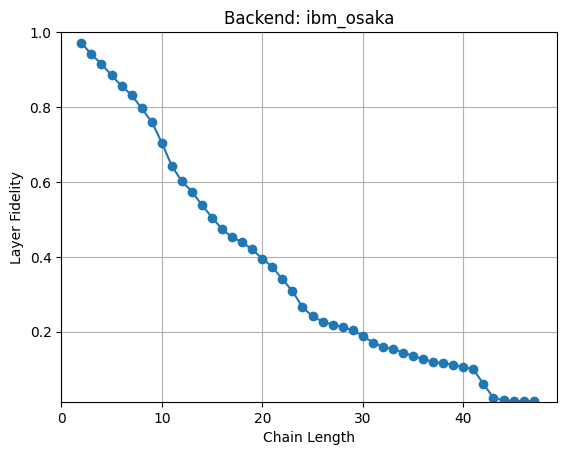

In [39]:
# Plot LF by chain length
plt.title(f"Backend: {BACKEND.name}")
plt.plot(
    chain_lens,
    chain_fids,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1] * 1.05)
plt.ylim(0.95 * min(chain_fids), 1)
plt.ylabel("Layer Fidelity")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

Then, at long last, we can calculate the EPLG as a function of chain length. EPLG is defined as
$$
EPLG = 1 − LF^{1/n_{2q}}
$$
where $n_{2q}$ is the number of two-qubit gates in all the layers

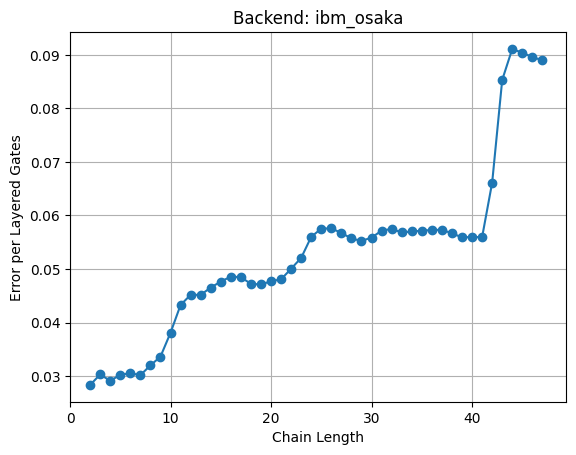

In [40]:
# Plot EPLG by chain length
num_2q_gates = [length - 1 for length in chain_lens]
chain_eplgs = [
    1 - (fid ** (1 / num_2q)) for num_2q, fid in zip(num_2q_gates, chain_fids)
]
plt.title(f"Backend: {BACKEND.name}")
plt.plot(
    chain_lens,
    chain_eplgs,
    marker="o",
    linestyle="-",
)
plt.xlim(0, chain_lens[-1] * 1.05)
plt.ylabel("Error per Layered Gates")
plt.xlabel("Chain Length")
plt.grid()
plt.show()

This analysis is very useful in diagnosing which qubits and devices to use for utility-scale workloads.

In [41]:
import datetime
from IPython.display import HTML, display


def qiskit_copyright(line="", cell=None):
    """IBM copyright"""
    now = datetime.datetime.now()

    html = "<div style='width: 100%; background-color:#d5d9e0;"
    html += "padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>"
    html += "<p>&copy; Copyright IBM 2017, %s.</p>" % now.year
    html += "<p>This code is licensed under the Apache License, Version 2.0. You may<br>"
    html += "obtain a copy of this license in the LICENSE.txt file in the root directory<br> "
    html += "of this source tree or at http://www.apache.org/licenses/LICENSE-2.0."

    html += "<p>Any modifications or derivative works of this code must retain this<br>"
    html += "copyright notice, and modified files need to carry a notice indicating<br>"
    html += "that they have been altered from the originals.</p>"
    html += "</div>"
    return display(HTML(html))


qiskit_copyright()